In [9]:
# 1. INSTALL & IMPORT LIBRARIES

!pip install opencv-python

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import zipfile


In [10]:
#MANUAL UPLOAD THE ZIP FILE IN COLAB

uploaded = files.upload()

zip_name = next(iter(uploaded))

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("Dataset extracted!")


Saving animal_dataset.zip to animal_dataset.zip
Dataset extracted!


In [33]:
DATASET_PATH = "dataset/"

X = []
y = []

all_items = os.listdir(DATASET_PATH)

if len(all_items) == 1 and os.path.isdir(os.path.join(DATASET_PATH, all_items[0])):
    DATASET_PATH = os.path.join(DATASET_PATH, all_items[0])
    print("Updated DATASET_PATH:", DATASET_PATH)

classes = sorted(os.listdir(DATASET_PATH))
print("Detected classes:", classes)

for label, c in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, c)

    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        if os.path.isdir(img_path):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print("Skipping unreadable file:", img_path)
            continue

        img = cv2.resize(img, (32, 32))
        img = img.flatten()

        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("\nFinal X shape =", X.shape)
print("Final y shape =", y.shape)
print("Number of classes =", len(set(y)))


Updated DATASET_PATH: dataset/animal_dataset
Detected classes: ['cat', 'dog', 'panda']

Final X shape = (300, 1024)
Final y shape = (300,)
Number of classes = 3


In [34]:
# KNN

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

class KNN:
    def __init__(self, K=3, distance='L2'):
        self.K = K
        self.distance = distance

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []

        for x in X_test:
            if self.distance == "L1":
                dist = np.sum(np.abs(self.X_train - x), axis=1)
            else:   # L2
                dist = np.sqrt(np.sum((self.X_train - x)**2, axis=1))

            # sort and take K nearest neighbors
            nn_idx = np.argsort(dist)[:self.K]
            nn_labels = self.y_train[nn_idx]

            # majority vote
            values, counts = np.unique(nn_labels, return_counts=True)
            y_pred.append(values[np.argmax(counts)])

        return np.array(y_pred)


In [35]:
def manual_cross_val(X, y, K_values, distance, seed=42):

    n = len(X)
    np.random.seed(seed)
    indices = np.arange(n)
    np.random.shuffle(indices)

    fold_size = n // 5
    scores = []

    for K in K_values:
        fold_acc = []

        for fold in range(5):
            start = fold * fold_size
            end = start + fold_size if fold < 4 else n

            val_idx = indices[start:end]
            train_idx = np.concatenate([indices[:start], indices[end:]])

            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            knn = KNN(K=K, distance=distance)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)

            accuracy = np.mean(y_pred == y_val)
            fold_acc.append(accuracy)

        scores.append(np.mean(fold_acc))

    return scores


K_values = [1, 3, 5, 7, 9]

acc_L1 = manual_cross_val(X, y, K_values, "L1")
acc_L2 = manual_cross_val(X, y, K_values, "L2")

print("Accuracy (L1):", acc_L1)
print("Accuracy (L2):", acc_L2)

Accuracy (L1): [np.float64(0.30333333333333334), np.float64(0.30666666666666664), np.float64(0.3166666666666666), np.float64(0.30999999999999994), np.float64(0.32)]
Accuracy (L2): [np.float64(0.33999999999999997), np.float64(0.33999999999999997), np.float64(0.37666666666666665), np.float64(0.38), np.float64(0.3933333333333333)]


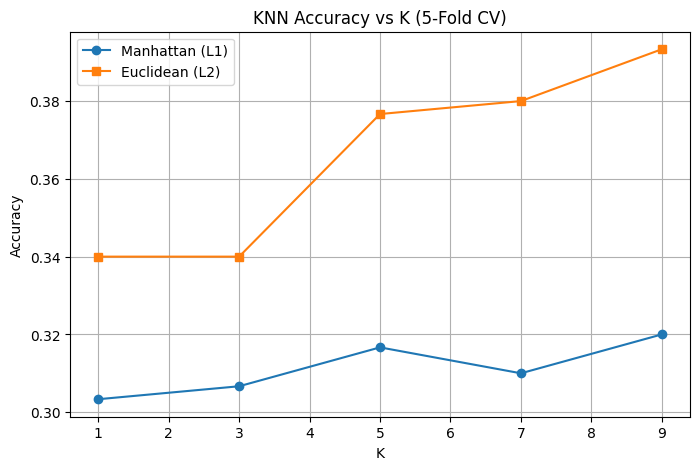

In [36]:
# PLOT ACCURACY GRAPH

plt.figure(figsize=(8, 5))
plt.plot(K_values, acc_L1, marker='o', label="Manhattan (L1)")
plt.plot(K_values, acc_L2, marker='s', label="Euclidean (L2)")

plt.title("KNN Accuracy vs K (5-Fold CV)")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


In [50]:
#Top 5 Predictions:
def knn_top5_with_result(x, X_train, y_train, distance_metric, classes):
    if distance_metric == "L1":
        dist = np.sum(np.abs(X_train - x), axis=1)
    else:
        dist = np.sqrt(np.sum((X_train - x)**2, axis=1))

    nn_idx = np.argsort(dist)
    top5_idx = nn_idx[:5]

    top5 = [(float(dist[i]), classes[int(y_train[i])]) for i in top5_idx]

    nn_labels = y_train[top5_idx]
    values, counts = np.unique(nn_labels, return_counts=True)
    final_pred = values[np.argmax(counts)]

    return top5, int(final_pred)
print("\n=== TOP-5 PREDICTIONS WITH TRUE/FALSE ===")

for i in range(5):
    top5, pred = knn_top5_with_result(X_test[i], X_train, y_train, "L2", classes)
    true_label = int(y_test[i])

    pred_name = classes[pred]
    true_name = classes[true_label]

    correctness = "CORRECT " if pred == true_label else "WRONG "

    print(f"\nImage {i}:")
    print(f"Predicted: {pred_name}  |  True: {true_name}  →  {correctness}")

    print("Top-5 nearest neighbors:")
    for d, name in top5:
        print(f"  Distance: {d:.2f}  →  Class: {name}")



=== TOP-5 PREDICTIONS WITH TRUE/FALSE ===

Image 0:
Predicted: cat  |  True: panda  →  WRONG 
Top-5 nearest neighbors:
  Distance: 315.22  →  Class: cat
  Distance: 315.44  →  Class: panda
  Distance: 316.19  →  Class: cat
  Distance: 316.66  →  Class: dog
  Distance: 316.94  →  Class: dog

Image 1:
Predicted: panda  |  True: cat  →  WRONG 
Top-5 nearest neighbors:
  Distance: 315.38  →  Class: cat
  Distance: 316.01  →  Class: dog
  Distance: 317.09  →  Class: panda
  Distance: 317.59  →  Class: panda
  Distance: 318.69  →  Class: panda

Image 2:
Predicted: dog  |  True: panda  →  WRONG 
Top-5 nearest neighbors:
  Distance: 317.24  →  Class: cat
  Distance: 318.39  →  Class: dog
  Distance: 318.55  →  Class: cat
  Distance: 318.65  →  Class: dog
  Distance: 318.85  →  Class: dog

Image 3:
Predicted: dog  |  True: cat  →  WRONG 
Top-5 nearest neighbors:
  Distance: 313.04  →  Class: dog
  Distance: 315.81  →  Class: dog
  Distance: 316.17  →  Class: cat
  Distance: 316.91  →  Class: d

Conclusion

From the graph, we can see that Euclidean distance (L2) gives better accuracy than Manhattan distance (L1) for all K values. L2 accuracy increases steadily as K becomes larger, while L1 stays lower and almost flat. This means L2 is better at measuring differences between gray-scale images in this dataset.

Overall, L2 is the better distance method for this problem.
L1 and L2 both have low accuracy because KNN is using raw pixel values, which is difficult for image classification. Accuracy could be improved by adding feature extraction or using more advanced models like CNNs.

Limitations & Potential Improvements

Limitations:

The model uses raw pixel values, which makes KNN struggle because the images are high-dimensional.

KNN is slow when the dataset is large, since it must compare every test image with all training images.

The accuracy is limited because KNN does not learn features; small pixel changes can confuse it.

No feature scaling or normalization was applied, which may affect distance calculations.

Potential Improvements:

Apply feature extraction  to reduce noise and dimensionality.

Normalize or standardize the images before training.

Use a weighted KNN where closer neighbors have more influence.

Try more advanced models.

Use dimensionality reduction to speed up KNN and improve accuracy.